# MIDAS

<font color="red"> **Note:** results for each experiment/training run are stored in `results` and the logs is where I obtain the confusion matrices and accuracy metrics at the best-performing epoch (on poster and in manuscript). Plots were generated in `plots.ipynb`</font>

Now that we have selected the best model trained on ISIC dev set only let's train it on the full ISIC 2019 training dataset to yield a best model without MIDAS fine tuning. We will then mesasure balanced multi-class accuracy (BMA) using the held out MIDAS 2019 test set. After this we will fine tune this model on MIDAS data to see if MIDAS fine-tuning can improve BMA score on ISIC test data.

1. Train on full ISIC 2019
  - Train `BaselineMLPHead` a.k.a. EfficientNet-B3 backcbone + MLP head (defined in `baseline_w_mlp.py`) as described on poster
  - Train `SwinClassifier` a.k.a. Swin backbone (defined in `swin.py`) as described on poster
2. Ensemble `BaselineMLPHead` and `SwinClassifier` and evluate on ISIC 2019 Test dataset using BMI as primary outcome
3. Fine tune on MIDAS
  - Fine tune `BaselineMLPHead`
  - Fine tune `SwinClassifier`
4. Ensemble fine-tuned `BaselineMLPHead` and `SwinClassifier` and evluate on ISCI 2019 Test dataset using BMI as primary outcome

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
project_root = "/content/drive/My Drive/midas"
if project_root not in sys.path:
    sys.path.append(project_root)

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
# from utils.dataloader import ISICDataset, MIDASDataset
from utils.preprocess import get_effnet_image_transform, get_swin_image_transform, load_full_isic
from utils.metrics import print_named_class_distribution, plot_class_distribution
import utils.dataloader
import src.trainer
from models.baseline_w_mlp import BaselineMLPHead
from models.swin import SwinClassifier
import torch.optim as optim
from pathlib import Path
from utils.eval import ensemble_predict
import importlib

# ensure latest functions loaded
importlib.reload(src.trainer)
importlib.reload(utils.dataloader)

<module 'utils.dataloader' from '/content/drive/My Drive/midas/utils/dataloader.py'>

In [ ]:
! pip install tqdm

## Load + Preprocess


### Load ISIC Train Data
Already obtained in `starter.ipynb`

In [ ]:
# full training data paths
base_dir = "/content/drive/My Drive/midas/data"
labels_path = os.path.join(base_dir, "ISIC_2019_Training_GroundTruth.csv")
meta_path = os.path.join(base_dir, "ISIC_2019_Training_Metadata.csv")
train_dir = os.path.join(base_dir, f"ISIC_2019_Training_Input")
test_dir = os.path.join(base_dir, f"ISIC_2019_Test_Input")

# load merged metadata + labels
train_df, index_to_label = load_full_isic(labels_path, meta_path)

Loaded 22480 images from full ISIC data set.


### Obtain ISIC Test Data
Since we have already picked a final model based on dev experiments (with the exception of MIDAS-fine tuning vs not), we will now use the ISIC test set to evaluate model training.

In [ ]:
# # OBTAIN TEST IMAGES

# base_dir = "/content/drive/My Drive/midas/data"
# os.makedirs(base_dir, exist_ok=True)

# # Step 1: Download Test Images (2.9 GB)
# !wget -O "{base_dir}/ISIC_2019_Test_Input.zip" \
#   "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Test_Input.zip"

# # Step 2: Download Ground Truth for Test Set
# !wget -O "{base_dir}/ISIC_2019_Test_GroundTruth.csv" \
#   "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Test_GroundTruth.csv"

# # Step 3: Download Metadata
# !wget -O "{base_dir}/ISIC_2019_Test_Metadata.csv" \
#   "https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Test_Metadata.csv"

# # Step 4: Unzip Test Images into base_dir
# !unzip "{base_dir}/ISIC_2019_Test_Input.zip" -d "{base_dir}"

# # Step 5: Remove ZIP to save space
# os.remove(f"{base_dir}/ISIC_2019_Test_Input.zip")

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057952.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057954.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057955.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057956.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057957.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057961.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057965.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057967.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057968.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/ISIC_0057971.jpg  
  inflating: /content/drive/My Drive/midas/data/ISIC_2019_Test_Input/

In [ ]:
test_labels = "/content/drive/My Drive/midas/data/ISIC_2019_Test_GroundTruth.csv"
test_meta = "/content/drive/My Drive/midas/data/ISIC_2019_Test_Metadata.csv"
test_df, index_to_label = load_full_isic(test_labels, test_meta)

Loaded 7537 images from full ISIC data set.



Train class distribution:
MEL   (0): 0.193
NV    (1): 0.473
BCC   (2): 0.144
AK    (3): 0.038
BKL   (4): 0.104
DF    (5): 0.010
VASC  (6): 0.010
SCC   (7): 0.028

Test class distribution:
MEL   (0): 0.433
NV    (1): 0.285
BCC   (2): 0.120
AK    (3): 0.048
BKL   (4): 0.074
DF    (5): 0.008
VASC  (6): 0.010
SCC   (7): 0.022


/content/drive/My Drive/midas/utils/metrics.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_labels), y=list(sorted_counts), palette="Set2")


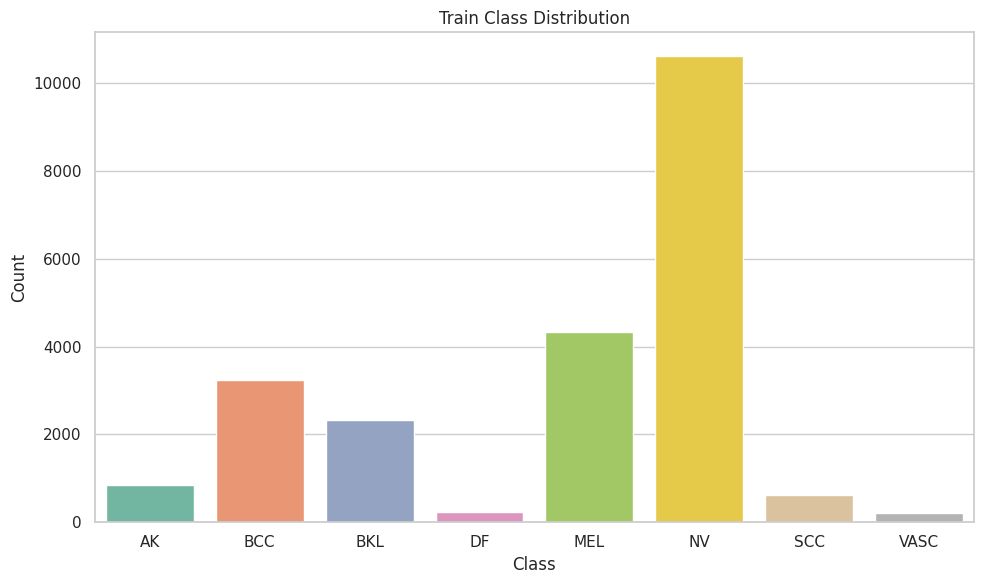

/content/drive/My Drive/midas/utils/metrics.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sorted_labels), y=list(sorted_counts), palette="Set2")


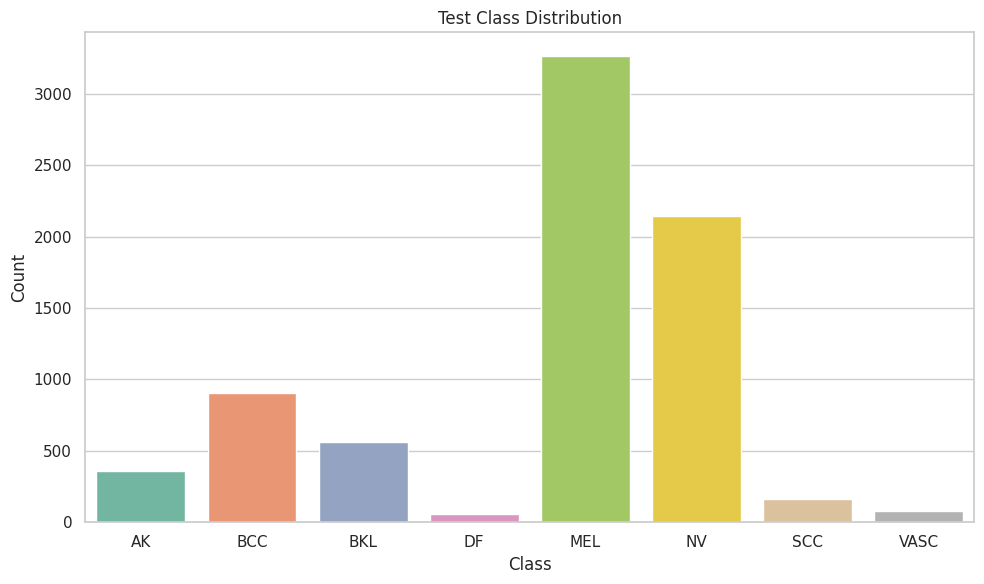

In [ ]:
figs_dir = '/content/drive/My Drive/midas/figs'

print_named_class_distribution(train_df, index_to_label, "Train class distribution")
print_named_class_distribution(test_df, index_to_label, "Test class distribution")
plot_class_distribution(train_df, index_to_label, title="Train Class Distribution", save_path=os.path.join(figs_dir, 'train_class_dist.jpeg'))
plot_class_distribution(test_df, index_to_label, title="Test Class Distribution", save_path=os.path.join(figs_dir, 'test_class_dist.jpeg'))


### Data Loaders

In [ ]:
# def safe_collate(batch):
#   '''
#   Skips corrupt samples
#   '''
#     batch = [b for b in batch if b is not None]
#     return None if len(batch)==0 else \
#         torch.utils.data.dataloader.default_collate(batch)

In [ ]:
BATCH_SIZE = 32

# ---- baseline model -----
effnet_transform = get_effnet_image_transform()
train_dataset_baseline = utils.dataloader.ISICDataset(train_dir, train_df, effnet_transform, index_to_label, use_metadata=False)
test_dataset_baseline = utils.dataloader.ISICDataset(test_dir, test_df, effnet_transform, index_to_label, use_metadata=False)
train_loader_baseline = DataLoader(
    train_dataset_baseline, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True)
test_loader_baseline = DataLoader(
    test_dataset_baseline, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True)

# ----- swin -----
swin_transform = get_swin_image_transform()
train_swin_dataset = utils.dataloader.ISICDataset(train_dir, train_df, swin_transform, index_to_label, use_metadata=False)
test_swin_dataset = utils.dataloader.ISICDataset(test_dir, test_df, swin_transform, index_to_label, use_metadata=False)
train_loader_swin = DataLoader(
    train_swin_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True)
test_loader_swin = DataLoader(
    test_swin_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True)

## Train Model
Both models in the ensemble are trained spearately

To keep runtime going:
```
function stayAwake() {
  console.log("Preventing idle disconnect...");
  document.querySelector("colab-toolbar-button#connect").click();
}
setInterval(stayAwake, 60000); // click every 60 sec
```

#### BaselineMLPHead

In [ ]:
from models.baseline_w_mlp import BaselineMLPHead

results_root = Path("/content/drive/MyDrive/midas/results")

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineMLPHead(num_classes=8).to(device)

# Define forward function for baseline model
def baseline_forward(model, batch):
    images, labels = batch
    images, labels = images.to(device), labels.long().to(device)
    return model(images)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

# Run training
src.trainer.train_model(
    model, train_loader_baseline, test_loader_baseline, train_df, index_to_label,
    forward_fn=baseline_forward,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    patience=5,
    experiment_name="final_baseline_mlp-head_lr-1e-4",
    results_root=results_root
)

CUDA available: True
Current device: 0


Val: 100%|██████████| 236/236 [01:22<00:00,  2.85it/s]



Epoch 1: Train Loss = 1.4231
Epoch 1: Val Loss = 1.5842, Val Acc = 0.4664
Val Acc = 0.4664, Val BMA = 0.5359
Classification Report:
              precision    recall  f1-score   support

         MEL       0.67      0.27      0.39      3266
          NV       0.85      0.68      0.76      2147
         BCC       0.44      0.67      0.53       903
          AK       0.21      0.67      0.31       362
         BKL       0.35      0.30      0.32       560
          DF       0.11      0.67      0.19        60
        VASC       0.07      0.66      0.12        76
         SCC       0.16      0.37      0.22       163

    accuracy                           0.47      7537
   macro avg       0.36      0.54      0.36      7537
weighted avg       0.63      0.47      0.49      7537

Confusion Matrix:
[[ 895  188  506  583  142  194  549  209]
 [ 312 1456  100   55  117   58   29   20]
 [  31   14  603  110   21   30   52   42]
 [  12    3   61  242   23    2    4   15]
 [  77   40   41  145  168

Val: 100%|██████████| 236/236 [01:22<00:00,  2.87it/s]



Epoch 2: Train Loss = 0.7937
Epoch 2: Val Loss = 1.7998, Val Acc = 0.4761
Val Acc = 0.4761, Val BMA = 0.5213
Classification Report:
              precision    recall  f1-score   support

         MEL       0.70      0.27      0.39      3266
          NV       0.84      0.71      0.77      2147
         BCC       0.38      0.69      0.49       903
          AK       0.21      0.45      0.29       362
         BKL       0.33      0.44      0.37       560
          DF       0.08      0.80      0.14        60
        VASC       0.10      0.47      0.16        76
         SCC       0.18      0.34      0.24       163

    accuracy                           0.48      7537
   macro avg       0.35      0.52      0.36      7537
weighted avg       0.63      0.48      0.50      7537

Confusion Matrix:
[[ 895  216  683  376  292  353  290  161]
 [ 280 1524   94   39  105   66   24   15]
 [  16   10  622   77   24  112   16   26]
 [   8    6   89  162   67    7    1   22]
 [  70   54   64   82  246

Val: 100%|██████████| 236/236 [01:21<00:00,  2.90it/s]



Epoch 3: Train Loss = 0.4856
Epoch 3: Val Loss = 1.9595, Val Acc = 0.5083
Val Acc = 0.5083, Val BMA = 0.5168
Classification Report:
              precision    recall  f1-score   support

         MEL       0.73      0.28      0.41      3266
          NV       0.76      0.79      0.77      2147
         BCC       0.39      0.78      0.52       903
          AK       0.21      0.54      0.30       362
         BKL       0.36      0.35      0.35       560
          DF       0.13      0.55      0.21        60
        VASC       0.13      0.47      0.20        76
         SCC       0.26      0.37      0.31       163

    accuracy                           0.51      7537
   macro avg       0.37      0.52      0.38      7537
weighted avg       0.62      0.51      0.51      7537

Confusion Matrix:
[[ 919  403  765  484  193  162  223  117]
 [ 205 1688   95   29   75   31   15    9]
 [  14   38  703   86   31   10    7   14]
 [  21   11   80  197   34    3    2   14]
 [  86   74   61  121  194

Val: 100%|██████████| 236/236 [01:22<00:00,  2.87it/s]



Epoch 4: Train Loss = 0.2899
Epoch 4: Val Loss = 2.2670, Val Acc = 0.5125
Val Acc = 0.5125, Val BMA = 0.5044
Classification Report:
              precision    recall  f1-score   support

         MEL       0.72      0.31      0.44      3266
          NV       0.79      0.74      0.77      2147
         BCC       0.37      0.81      0.51       903
          AK       0.24      0.33      0.28       362
         BKL       0.31      0.48      0.38       560
          DF       0.17      0.60      0.26        60
        VASC       0.13      0.38      0.19        76
         SCC       0.18      0.38      0.25       163

    accuracy                           0.51      7537
   macro avg       0.36      0.50      0.38      7537
weighted avg       0.62      0.51      0.52      7537

Confusion Matrix:
[[1022  336  863  229  335  127  180  174]
 [ 247 1595  108   21  136   27    4    9]
 [  23   26  731   38   40   11    6   28]
 [  27    6   99  118   75    0    1   36]
 [  86   43   65   64  270

Val: 100%|██████████| 236/236 [01:21<00:00,  2.88it/s]



Epoch 5: Train Loss = 0.1592
Epoch 5: Val Loss = 2.4596, Val Acc = 0.5433
Val Acc = 0.5433, Val BMA = 0.5134
Classification Report:
              precision    recall  f1-score   support

         MEL       0.75      0.35      0.47      3266
          NV       0.71      0.81      0.76      2147
         BCC       0.42      0.76      0.54       903
          AK       0.26      0.53      0.35       362
         BKL       0.36      0.41      0.38       560
          DF       0.17      0.55      0.27        60
        VASC       0.18      0.38      0.25        76
         SCC       0.25      0.32      0.28       163

    accuracy                           0.54      7537
   macro avg       0.39      0.51      0.41      7537
weighted avg       0.63      0.54      0.54      7537

Confusion Matrix:
[[1128  561  665  347  240  105  120  100]
 [ 184 1748   78   23   86   21    2    5]
 [  31   52  682   70   30   10    7   21]
 [  34   13   70  191   45    0    1    8]
 [  94   71   62   82  232

Val: 100%|██████████| 236/236 [01:20<00:00,  2.94it/s]


Epoch 6: Train Loss = 0.1064
Epoch 6: Val Loss = 2.8288, Val Acc = 0.5306
Val Acc = 0.5306, Val BMA = 0.5090
Classification Report:
              precision    recall  f1-score   support

         MEL       0.72      0.34      0.46      3266
          NV       0.72      0.78      0.75      2147
         BCC       0.37      0.83      0.51       903
          AK       0.27      0.32      0.29       362
         BKL       0.39      0.39      0.39       560
          DF       0.20      0.47      0.28        60
        VASC       0.19      0.50      0.27        76
         SCC       0.24      0.44      0.31       163

    accuracy                           0.53      7537
   macro avg       0.39      0.51      0.41      7537
weighted avg       0.61      0.53      0.53      7537

Confusion Matrix:
[[1098  508  883  197  205   84  146  145]
 [ 268 1673  101   15   60   12   12    6]
 [  24   41  754   31   13    4    7   29]
 [  34   10  124  116   60    0    1   17]
 [  90   85   85   52  220

([1.423103149590543,
  0.7937416290473259,
  0.48558225588230053,
  0.28990436163979494,
  0.159224409058531,
  0.10638498771551241],
 [1.584206430890191,
  1.7997663865216582,
  1.9595065649267183,
  2.267040763528274,
  2.459579192249247,
  2.828834641560234],
 'MyDrive/midas/results/final_baseline_mlp-head_lr-1e-4_20250604_231548/best_model.pt')

#### Reflections

Train and test diverge as training goes onward. The likely strongest contributor to this is class imbalance between train and test. This imbalance was not present during our dev runs, because the validation set in that case was a subset of train. The class imbalance is likely an intentional decision by ISIC to reward models that are more generalizable, because false negatives of rare but seriuos disease diagnoses are far more harmful than false posities. In summary, the distirbution shift was to reward for generalization over memorization and served as a stress test for clinical safety.

#### SwinClassifier

In [ ]:
from models.swin import SwinClassifier

results_root = Path("/content/drive/MyDrive/midas/results")

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinClassifier(num_classes=8).to(device)

# Define forward function for Swin model
def swin_forward(model, batch):
    images, labels = batch
    return model(images)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

# Run training
src.trainer.train_model(
    model, train_loader_swin, test_loader_swin, train_df, index_to_label,
    forward_fn=swin_forward,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    patience=5,
    experiment_name="final_swin_lr-1e-4",
    results_root=results_root
)

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

CUDA available: True
Current device: 0


Val: 100%|██████████| 236/236 [01:14<00:00,  3.18it/s]



Epoch 1: Train Loss = 1.3921
Epoch 1: Val Loss = 1.7032, Val Acc = 0.4828
Val Acc = 0.4828, Val BMA = 0.4834
Classification Report:
              precision    recall  f1-score   support

         MEL       0.68      0.28      0.40      3266
          NV       0.76      0.78      0.77      2147
         BCC       0.41      0.70      0.51       903
          AK       0.20      0.41      0.27       362
         BKL       0.31      0.20      0.24       560
          DF       0.17      0.45      0.25        60
        VASC       0.11      0.51      0.18        76
         SCC       0.11      0.53      0.18       163

    accuracy                           0.48      7537
   macro avg       0.34      0.48      0.35      7537
weighted avg       0.60      0.48      0.49      7537

Confusion Matrix:
[[ 927  392  615  360  155   99  247  471]
 [ 237 1668  124   34   42   12   21    9]
 [  17   27  630   75   18    5   27  104]
 [  25   14   66  149   27    1    2   78]
 [ 138   93   77   75  112

Val: 100%|██████████| 236/236 [01:12<00:00,  3.24it/s]



Epoch 2: Train Loss = 0.9543
Epoch 2: Val Loss = 1.8027, Val Acc = 0.4199
Val Acc = 0.4199, Val BMA = 0.4676
Classification Report:
              precision    recall  f1-score   support

         MEL       0.78      0.23      0.36      3266
          NV       0.81      0.58      0.67      2147
         BCC       0.42      0.67      0.51       903
          AK       0.17      0.07      0.10       362
         BKL       0.19      0.72      0.30       560
          DF       0.07      0.63      0.12        60
        VASC       0.13      0.39      0.19        76
         SCC       0.15      0.45      0.23       163

    accuracy                           0.42      7537
   macro avg       0.34      0.47      0.31      7537
weighted avg       0.65      0.42      0.44      7537

Confusion Matrix:
[[ 754  255  548   81  839  332  178  279]
 [ 139 1237   90    9  619   31    4   18]
 [  14    9  605   14   91  101   13   56]
 [   1    2  112   24  167   13    2   41]
 [  37   13   50    8  404

Val: 100%|██████████| 236/236 [01:14<00:00,  3.19it/s]



Epoch 3: Train Loss = 0.7074
Epoch 3: Val Loss = 1.8166, Val Acc = 0.4823
Val Acc = 0.4823, Val BMA = 0.4974
Classification Report:
              precision    recall  f1-score   support

         MEL       0.67      0.31      0.42      3266
          NV       0.79      0.66      0.72      2147
         BCC       0.44      0.68      0.53       903
          AK       0.17      0.64      0.27       362
         BKL       0.33      0.42      0.37       560
          DF       0.24      0.40      0.30        60
        VASC       0.10      0.41      0.17        76
         SCC       0.20      0.46      0.28       163

    accuracy                           0.48      7537
   macro avg       0.37      0.50      0.38      7537
weighted avg       0.61      0.48      0.50      7537

Confusion Matrix:
[[1013  326  548  713  194   63  226  183]
 [ 347 1409   75   56  228    6   10   16]
 [  20   16  614  165   17    2    9   60]
 [  15    1   56  233   28    0    8   21]
 [  91   22   50  140  236

Val: 100%|██████████| 236/236 [01:14<00:00,  3.15it/s]



Epoch 4: Train Loss = 0.5664
Epoch 4: Val Loss = 2.0422, Val Acc = 0.4792
Val Acc = 0.4792, Val BMA = 0.5201
Classification Report:
              precision    recall  f1-score   support

         MEL       0.73      0.25      0.37      3266
          NV       0.79      0.72      0.76      2147
         BCC       0.35      0.78      0.49       903
          AK       0.19      0.49      0.27       362
         BKL       0.37      0.35      0.36       560
          DF       0.13      0.52      0.21        60
        VASC       0.19      0.43      0.26        76
         SCC       0.17      0.61      0.27       163

    accuracy                           0.48      7537
   macro avg       0.37      0.52      0.37      7537
weighted avg       0.63      0.48      0.49      7537

Confusion Matrix:
[[ 823  320  896  463  206  143  128  287]
 [ 242 1546  161   55   75   31    2   35]
 [   8   11  704  101   15   12    6   46]
 [   7    2   90  179   33    1    3   47]
 [  43   62   82  108  196

Val: 100%|██████████| 236/236 [01:14<00:00,  3.18it/s]



Epoch 5: Train Loss = 0.2974
Epoch 5: Val Loss = 2.3023, Val Acc = 0.5286
Val Acc = 0.5286, Val BMA = 0.5205
Classification Report:
              precision    recall  f1-score   support

         MEL       0.78      0.31      0.45      3266
          NV       0.77      0.78      0.77      2147
         BCC       0.37      0.80      0.51       903
          AK       0.27      0.51      0.35       362
         BKL       0.36      0.48      0.41       560
          DF       0.20      0.48      0.28        60
        VASC       0.13      0.42      0.20        76
         SCC       0.21      0.38      0.27       163

    accuracy                           0.53      7537
   macro avg       0.39      0.52      0.41      7537
weighted avg       0.65      0.53      0.53      7537

Confusion Matrix:
[[1019  415  853  312  255   85  177  150]
 [ 184 1664  122   37  109    8   12   11]
 [  17   18  725   46   37   13   18   29]
 [  12    6   84  185   45    0    7   23]
 [  61   49   80   80  268

Val: 100%|██████████| 236/236 [01:13<00:00,  3.20it/s]



Epoch 6: Train Loss = 0.1734
Epoch 6: Val Loss = 2.6531, Val Acc = 0.5241
Val Acc = 0.5241, Val BMA = 0.4997
Classification Report:
              precision    recall  f1-score   support

         MEL       0.72      0.34      0.46      3266
          NV       0.78      0.72      0.75      2147
         BCC       0.38      0.80      0.51       903
          AK       0.24      0.40      0.30       362
         BKL       0.30      0.53      0.39       560
          DF       0.22      0.43      0.30        60
        VASC       0.23      0.37      0.28        76
         SCC       0.26      0.40      0.32       163

    accuracy                           0.52      7537
   macro avg       0.39      0.50      0.41      7537
weighted avg       0.62      0.52      0.53      7537

Confusion Matrix:
[[1117  361  869  281  362   68   90  118]
 [ 296 1549   79   25  174    6    3   15]
 [  24   29  723   57   39    8    2   21]
 [  22    7   84  143   85    1    1   19]
 [  83   35   74   54  298

Val: 100%|██████████| 236/236 [01:12<00:00,  3.26it/s]



Epoch 7: Train Loss = 0.1567
Epoch 7: Val Loss = 2.7705, Val Acc = 0.5318
Val Acc = 0.5318, Val BMA = 0.4880
Classification Report:
              precision    recall  f1-score   support

         MEL       0.74      0.36      0.48      3266
          NV       0.73      0.79      0.76      2147
         BCC       0.42      0.70      0.52       903
          AK       0.17      0.38      0.23       362
         BKL       0.35      0.44      0.39       560
          DF       0.25      0.45      0.33        60
        VASC       0.19      0.39      0.26        76
         SCC       0.21      0.39      0.27       163

    accuracy                           0.53      7537
   macro avg       0.38      0.49      0.40      7537
weighted avg       0.62      0.53      0.54      7537

Confusion Matrix:
[[1176  477  637  433  245   65  111  122]
 [ 216 1695   76   36  103    6    6    9]
 [  35   44  631  101   39    5    6   42]
 [  39   17   54  138   61    0    4   49]
 [  90   72   55   76  248

Val: 100%|██████████| 236/236 [01:13<00:00,  3.21it/s]



Epoch 8: Train Loss = 0.0924
Epoch 8: Val Loss = 3.2986, Val Acc = 0.5470
Val Acc = 0.5470, Val BMA = 0.4903
Classification Report:
              precision    recall  f1-score   support

         MEL       0.74      0.36      0.48      3266
          NV       0.69      0.83      0.75      2147
         BCC       0.39      0.80      0.52       903
          AK       0.29      0.31      0.30       362
         BKL       0.40      0.41      0.40       560
          DF       0.24      0.42      0.30        60
        VASC       0.23      0.41      0.30        76
         SCC       0.21      0.40      0.27       163

    accuracy                           0.55      7537
   macro avg       0.40      0.49      0.42      7537
weighted avg       0.61      0.55      0.54      7537

Confusion Matrix:
[[1163  618  829  167  192   63   93  141]
 [ 205 1779   76   16   51    6    2   12]
 [  30   54  719   32   32    5    2   29]
 [  48   21   88  112   52    0    3   38]
 [ 101   95   64   43  229

Val: 100%|██████████| 236/236 [01:13<00:00,  3.19it/s]



Epoch 9: Train Loss = 0.0585
Epoch 9: Val Loss = 3.7000, Val Acc = 0.5435
Val Acc = 0.5435, Val BMA = 0.4837
Classification Report:
              precision    recall  f1-score   support

         MEL       0.77      0.34      0.47      3266
          NV       0.68      0.86      0.76      2147
         BCC       0.41      0.74      0.53       903
          AK       0.22      0.34      0.27       362
         BKL       0.33      0.42      0.37       560
          DF       0.24      0.43      0.31        60
        VASC       0.22      0.37      0.27        76
         SCC       0.27      0.36      0.31       163

    accuracy                           0.54      7537
   macro avg       0.39      0.48      0.41      7537
weighted avg       0.62      0.54      0.54      7537

Confusion Matrix:
[[1111  665  699  265  271   64   92   99]
 [ 137 1839   51   22   82    5    2    9]
 [  27   67  672   65   46    4    3   19]
 [  45   16   92  123   68    0    4   14]
 [  91  102   54   58  238

Val: 100%|██████████| 236/236 [01:12<00:00,  3.26it/s]


Epoch 10: Train Loss = 0.0526
Epoch 10: Val Loss = 3.6702, Val Acc = 0.5423
Val Acc = 0.5423, Val BMA = 0.4993
Classification Report:
              precision    recall  f1-score   support

         MEL       0.77      0.33      0.46      3266
          NV       0.71      0.83      0.76      2147
         BCC       0.40      0.79      0.53       903
          AK       0.24      0.37      0.29       362
         BKL       0.34      0.47      0.39       560
          DF       0.24      0.42      0.30        60
        VASC       0.22      0.39      0.28        76
         SCC       0.22      0.40      0.29       163

    accuracy                           0.54      7537
   macro avg       0.39      0.50      0.41      7537
weighted avg       0.63      0.54      0.54      7537

Confusion Matrix:
[[1078  577  758  253  301   65   97  137]
 [ 160 1781   76   21   90    5    2   12]
 [  20   47  713   55   36    4    3   25]
 [  28   17   91  133   59    0    3   31]
 [  92   68   61   54  2

([1.3921212420344777,
  0.9542552567461632,
  0.7073762151058034,
  0.5663708776765871,
  0.2973864861972816,
  0.17344478982570333,
  0.15665086943961123,
  0.09236965989229995,
  0.05851444632935195,
  0.05262829624033563],
 [1.7031681584286977,
  1.802675431534199,
  1.8166003007858427,
  2.042245668806289,
  2.3022979768214276,
  2.653105813090074,
  2.770540614271727,
  3.298579657284986,
  3.6999895218371774,
  3.6701852090956284],
 'MyDrive/midas/results/final_swin_lr-1e-4_20250605_000442/best_model.pt')

#### Reflections

Using `SwinClassifier` the val loss actually decreases with train loss, unlike for `BaselineMLPHead`! This demonstrates that ViTs may be detecting more generalizable patterns.

### Ensemble

In [ ]:
from models.baseline_w_mlp import BaselineMLPHead
from models.swin import SwinClassifier
from utils.eval import ensemble_predict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load MLPFusionModel ---
meta_dim = 12  # required to match the saved checkpoint
mlp_model = BaselineMLPHead (num_classes=8, hidden_dim=256)
mlp_model.load_state_dict(torch.load(
    "/content/drive/MyDrive/midas/results/final_baseline_mlp-head_lr-1e-4_20250604_231548/best_model.pt",
    map_location=device
))
mlp_model = mlp_model.to(device).eval()

# --- Load Swin Model ---
swin_model = SwinClassifier(num_classes=8)
swin_model.load_state_dict(torch.load(
    "/content/drive/MyDrive/midas/results/final_swin_lr-1e-4_20250605_000442/best_model.pt",
    map_location=device
))
swin_model = swin_model.to(device).eval()

# --- Ensemble Predict (Requires two separate loaders) ---
# create loaders
transform_swin = get_swin_image_transform() # 224×224, no metadata
transform_mlp = get_effnet_image_transform() # 300×300, with metadata
val_dataset_swin = ISICDataset(test_dir, test_df, transform_swin, index_to_label, use_metadata=False)
val_dataset_mlp = ISICDataset(test_dir, test_df, transform_mlp, index_to_label, use_metadata=False)
val_loader_swin = DataLoader(val_dataset_swin, batch_size=BATCH_SIZE, shuffle=False)
val_loader_mlp = DataLoader(val_dataset_mlp, batch_size=BATCH_SIZE, shuffle=False)
# enseble models
models = [mlp_model, swin_model]
dataloaders = [val_loader_mlp, val_loader_swin]
final_preds, true_labels, acc, bma = ensemble_predict(
    models, dataloaders, device, weights=[0.3, 0.7]
)
print(f"✅ Ensemble Accuracy: {acc:.4f}")
print(f"📊 Balanced Multiclass Accuracy (BMA): {bma:.4f}")


✅ Ensemble Accuracy: 0.5311
📊 Balanced Multiclass Accuracy (BMA): 0.5394


## Fine-tune on MIDAS

In [ ]:

BATCH_SIZE = 32

# full training data paths
base_dir_midas = "/content/drive/My Drive/midas/data_midas"
train_dir_midas = os.path.join(base_dir_midas, "MIDAS_GroundTruth_clean.csv")
train_df_midas = pd.read_csv(train_dir_midas)
train_df_midas = train_df_midas.rename(columns={"isic_label": "label"})
img_dir_midas = os.path.join(base_dir_midas)

# ---- baseline model -----
effnet_transform = get_effnet_image_transform()
train_dataset_baseline_midas = utils.dataloader.MIDASDataset(train_dir_midas, img_dir_midas, effnet_transform)
test_dataset_baseline = utils.dataloader.ISICDataset(test_dir, test_df, effnet_transform, use_metadata=False)
train_loader_baseline_midas = DataLoader(train_dataset_baseline_midas, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_baseline = DataLoader(test_dataset_baseline, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ----- swin -----
swin_transform = get_swin_image_transform()
train_dataset_swin_midas = utils.dataloader.MIDASDataset(train_dir_midas, img_dir_midas, swin_transform)
test_dataset_swin = utils.dataloader.ISICDataset(test_dir, test_df, swin_transform, use_metadata=False)
train_loader_swin_midas = DataLoader(train_dataset_swin_midas, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader_swin = DataLoader(test_dataset_swin, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


### BaselineMLPHead

In [ ]:
from models.baseline_w_mlp import BaselineMLPHead

results_root = Path("/content/drive/MyDrive/midas/results")
pretrained_baseline_path = os.path.join(results_root, 'final_baseline_mlp-head_lr-1e-4_20250604_231548/best_model.pt')

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BaselineMLPHead(num_classes=8).to(device)
# load pretrained weights
model.load_state_dict(torch.load(pretrained_baseline_path, map_location=device))
print(f"✅ Loaded pretrained weights from {pretrained_baseline_path}")

# Define forward function for baseline model
def baseline_forward(model, batch):
    images, labels = batch
    images, labels = images.to(device), labels.long().to(device)
    return model(images)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

# Run training
src.trainer.train_model(
    model, train_loader_baseline_midas, test_loader_baseline, train_df_midas, index_to_label,
    forward_fn=baseline_forward,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    patience=5,
    experiment_name="midas_baseline_mlp-head_lr-1e-4",
    results_root=results_root
)

✅ Loaded pretrained weights from /content/drive/MyDrive/midas/results/final_baseline_mlp-head_lr-1e-4_20250604_231548/best_model.pt
CUDA available: True
Current device: 0


Val: 100%|██████████| 236/236 [01:22<00:00,  2.87it/s]



Epoch 1: Train Loss = 1.5221
Epoch 1: Val Loss = 1.8550, Val Acc = 0.3271
Val Acc = 0.3271, Val BMA = 0.2967
Classification Report:
              precision    recall  f1-score   support

         MEL       0.58      0.16      0.25      3266
          NV       0.79      0.70      0.74      2147
         BCC       0.67      0.00      0.01       903
          AK       0.16      0.12      0.14       362
         BKL       0.16      0.40      0.23       560
          DF       0.11      0.02      0.03        60
        VASC       0.12      0.08      0.10        76
         SCC       0.05      0.88      0.09       163

    accuracy                           0.33      7537
   macro avg       0.33      0.30      0.20      7537
weighted avg       0.58      0.33      0.35      7537

Confusion Matrix:
[[ 532  275    2  173  633    8   38 1605]
 [ 258 1509    0   10  239    0    0  131]
 [  34   41    4   28  140    0    0  656]
 [  12    3    0   45  122    0    2  178]
 [  71   61    0   21  224

Val: 100%|██████████| 236/236 [01:19<00:00,  2.95it/s]



Epoch 2: Train Loss = 1.0555
Epoch 2: Val Loss = 1.8403, Val Acc = 0.3509
Val Acc = 0.3509, Val BMA = 0.3278
Classification Report:
              precision    recall  f1-score   support

         MEL       0.59      0.19      0.29      3266
          NV       0.77      0.71      0.74      2147
         BCC       0.52      0.01      0.03       903
          AK       0.14      0.29      0.19       362
         BKL       0.14      0.43      0.21       560
          DF       0.00      0.00      0.00        60
        VASC       0.22      0.20      0.21        76
         SCC       0.07      0.79      0.13       163

    accuracy                           0.35      7537
   macro avg       0.31      0.33      0.22      7537
weighted avg       0.56      0.35      0.37      7537

Confusion Matrix:
[[ 628  317    9  450  862    2   48  950]
 [ 275 1514    0   24  252    0    0   82]
 [  54   40   12  119  218    0    2  458]
 [  16   10    2  106  132    0    2   94]
 [  90   66    0   38  241

Val: 100%|██████████| 236/236 [01:20<00:00,  2.92it/s]



Epoch 3: Train Loss = 0.7578
Epoch 3: Val Loss = 1.9712, Val Acc = 0.3630
Val Acc = 0.3630, Val BMA = 0.3325
Classification Report:
              precision    recall  f1-score   support

         MEL       0.60      0.21      0.31      3266
          NV       0.79      0.70      0.74      2147
         BCC       0.49      0.05      0.09       903
          AK       0.16      0.22      0.19       362
         BKL       0.13      0.47      0.21       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.20      0.21        76
         SCC       0.07      0.80      0.13       163

    accuracy                           0.36      7537
   macro avg       0.31      0.33      0.23      7537
weighted avg       0.57      0.36      0.39      7537

Confusion Matrix:
[[ 696  282   36  295 1023    1   47  886]
 [ 268 1504    4   21  274    0    0   76]
 [  71   34   45   72  226    0    5  450]
 [  13    8    2   81  147    0    1  110]
 [ 101   64    4   19  264

Val: 100%|██████████| 236/236 [01:22<00:00,  2.86it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


Epoch 4: Train Loss = 0.4942
Epoch 4: Val Loss = 2.0254, Val Acc = 0.3764
Val Acc = 0.3764, Val BMA = 0.3330
Classification Report:
              precision    recall  f1-score   support

         MEL       0.55      0.27      0.36      3266
          NV       0.78      0.63      0.70      2147
         BCC       0.45      0.10      0.16       903
          AK       0.18      0.29      0.22       362
         BKL       0.13      0.51      0.20       560
          DF       0.00      0.00      0.00        60
        VASC       0.24      0.18      0.21        76
         SCC       0.10      0.67      0.18       163

    accuracy                           0.38      7537
   macro avg       0.30      0.33      0.25      7537
weighted avg       0.54      0.38      0.41      7537

Confusion Matrix:
[[ 871  286   88  346 1105    0   36  534]
 [ 440 1359    4   24  287    0    0   33]
 [ 107   28   90   72  345    0    4  257]
 [  23    9    6  106  155    0    2   61]
 [ 131   44    5   21  287

Val: 100%|██████████| 236/236 [01:23<00:00,  2.84it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


Epoch 5: Train Loss = 0.3245
Epoch 5: Val Loss = 2.1760, Val Acc = 0.3915
Val Acc = 0.3915, Val BMA = 0.3326
Classification Report:
              precision    recall  f1-score   support

         MEL       0.60      0.24      0.34      3266
          NV       0.74      0.69      0.71      2147
         BCC       0.42      0.22      0.29       903
          AK       0.18      0.32      0.23       362
         BKL       0.12      0.50      0.20       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.17      0.19        76
         SCC       0.11      0.52      0.18       163

    accuracy                           0.39      7537
   macro avg       0.30      0.33      0.27      7537
weighted avg       0.54      0.39      0.42      7537

Confusion Matrix:
[[ 775  370  216  344 1129    0   42  390]
 [ 287 1482   17   29  307    0    0   25]
 [  91   55  200   78  303    0    4  172]
 [  20   12   19  115  153    0    1   42]
 [ 100   74    5   28  281

Val: 100%|██████████| 236/236 [01:23<00:00,  2.82it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


Epoch 6: Train Loss = 0.2395
Epoch 6: Val Loss = 2.4446, Val Acc = 0.3807
Val Acc = 0.3807, Val BMA = 0.3252
Classification Report:
              precision    recall  f1-score   support

         MEL       0.61      0.22      0.32      3266
          NV       0.75      0.69      0.72      2147
         BCC       0.40      0.18      0.25       903
          AK       0.18      0.27      0.21       362
         BKL       0.12      0.55      0.20       560
          DF       0.00      0.00      0.00        60
        VASC       0.31      0.17      0.22        76
         SCC       0.10      0.52      0.17       163

    accuracy                           0.38      7537
   macro avg       0.31      0.33      0.26      7537
weighted avg       0.55      0.38      0.41      7537

Confusion Matrix:
[[ 711  343  196  318 1254    0   24  420]
 [ 273 1491   12   22  316    0    0   33]
 [  73   49  167   68  350    0    4  192]
 [  14   11   18   96  171    0    1   51]
 [  87   80    7   18  306

Val: 100%|██████████| 236/236 [01:24<00:00,  2.81it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


Epoch 7: Train Loss = 0.1800
Epoch 7: Val Loss = 2.4506, Val Acc = 0.4029
Val Acc = 0.4029, Val BMA = 0.3234
Classification Report:
              precision    recall  f1-score   support

         MEL       0.61      0.26      0.37      3266
          NV       0.69      0.70      0.70      2147
         BCC       0.38      0.23      0.29       903
          AK       0.23      0.22      0.22       362
         BKL       0.12      0.50      0.20       560
          DF       0.00      0.00      0.00        60
        VASC       0.29      0.17      0.21        76
         SCC       0.11      0.49      0.18       163

    accuracy                           0.40      7537
   macro avg       0.30      0.32      0.27      7537
weighted avg       0.53      0.40      0.43      7537

Confusion Matrix:
[[ 863  445  265  196 1136    0   27  334]
 [ 314 1508   21   12  264    0    0   28]
 [  91   76  212   42  317    0    4  161]
 [  25   21   23   81  162    0    1   49]
 [ 112   86   13   12  280

Val: 100%|██████████| 236/236 [01:25<00:00,  2.77it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


Epoch 8: Train Loss = 0.1472
Epoch 8: Val Loss = 2.5989, Val Acc = 0.4076
Val Acc = 0.4076, Val BMA = 0.3313
Classification Report:
              precision    recall  f1-score   support

         MEL       0.62      0.23      0.34      3266
          NV       0.69      0.71      0.70      2147
         BCC       0.37      0.38      0.38       903
          AK       0.24      0.25      0.24       362
         BKL       0.14      0.52      0.21       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.17      0.19        76
         SCC       0.10      0.40      0.17       163

    accuracy                           0.41      7537
   macro avg       0.30      0.33      0.28      7537
weighted avg       0.54      0.41      0.42      7537

Confusion Matrix:
[[ 755  476  418  196 1080    0   41  300]
 [ 265 1519   38   14  283    0    0   28]
 [  73   76  340   42  248    0    4  120]
 [  18   19   41   89  152    0    2   41]
 [  93   83   23   14  291

Val: 100%|██████████| 236/236 [01:26<00:00,  2.73it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


Epoch 9: Train Loss = 0.1230
Epoch 9: Val Loss = 2.6011, Val Acc = 0.4067
Val Acc = 0.4067, Val BMA = 0.3394
Classification Report:
              precision    recall  f1-score   support

         MEL       0.62      0.24      0.34      3266
          NV       0.69      0.70      0.70      2147
         BCC       0.38      0.36      0.37       903
          AK       0.24      0.22      0.23       362
         BKL       0.13      0.50      0.21       560
          DF       0.00      0.00      0.00        60
        VASC       0.22      0.17      0.19        76
         SCC       0.11      0.53      0.18       163

    accuracy                           0.41      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.41      0.42      7537

Confusion Matrix:
[[ 778  452  394  176 1036    0   39  391]
 [ 282 1506   36   10  281    0    0   32]
 [  72   72  323   32  260    0    4  140]
 [  18   19   41   80  149    0    2   53]
 [ 100   83   21   15  279

Val: 100%|██████████| 236/236 [01:24<00:00,  2.78it/s]



Epoch 10: Train Loss = 0.1074
Epoch 10: Val Loss = 2.7019, Val Acc = 0.4072
Val Acc = 0.4072, Val BMA = 0.3372
Classification Report:
              precision    recall  f1-score   support

         MEL       0.62      0.25      0.35      3266
          NV       0.70      0.68      0.69      2147
         BCC       0.37      0.38      0.37       903
          AK       0.23      0.22      0.22       362
         BKL       0.14      0.52      0.21       560
          DF       0.00      0.00      0.00        60
        VASC       0.24      0.17      0.20        76
         SCC       0.11      0.49      0.18       163

    accuracy                           0.41      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.41      0.43      7537

Confusion Matrix:
[[ 807  424  428  177 1049    1   36  344]
 [ 301 1463   37   14  301    0    0   31]
 [  73   70  339   33  257    0    4  127]
 [  24   17   47   78  146    0    1   49]
 [ 100   74   25   14  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.81it/s]



Epoch 11: Train Loss = 0.0923
Epoch 11: Val Loss = 2.7176, Val Acc = 0.4137
Val Acc = 0.4137, Val BMA = 0.3347
Classification Report:
              precision    recall  f1-score   support

         MEL       0.63      0.24      0.35      3266
          NV       0.67      0.73      0.70      2147
         BCC       0.36      0.35      0.36       903
          AK       0.26      0.23      0.25       362
         BKL       0.14      0.48      0.21       560
          DF       0.00      0.00      0.00        60
        VASC       0.25      0.17      0.20        76
         SCC       0.11      0.47      0.18       163

    accuracy                           0.41      7537
   macro avg       0.30      0.33      0.28      7537
weighted avg       0.54      0.41      0.43      7537

Confusion Matrix:
[[ 797  509  414  173 1002    1   33  337]
 [ 259 1557   36   11  253    0    0   31]
 [  79   89  320   32  234    0    4  145]
 [  20   22   45   85  144    0    1   45]
 [  99   96   24   14  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.78it/s]



Epoch 12: Train Loss = 0.0812
Epoch 12: Val Loss = 2.8332, Val Acc = 0.4159
Val Acc = 0.4159, Val BMA = 0.3399
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.22      0.32      3266
          NV       0.67      0.75      0.71      2147
         BCC       0.37      0.41      0.39       903
          AK       0.28      0.22      0.25       362
         BKL       0.14      0.51      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.22      0.17      0.19        76
         SCC       0.11      0.44      0.18       163

    accuracy                           0.42      7537
   macro avg       0.31      0.34      0.28      7537
weighted avg       0.55      0.42      0.42      7537

Confusion Matrix:
[[ 703  532  469  150 1053    1   37  321]
 [ 187 1613   38    9  274    0    0   26]
 [  65   89  369   24  236    0    5  115]
 [  16   25   52   81  147    0    2   39]
 [  85   99   30   12  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.78it/s]



Epoch 13: Train Loss = 0.0837
Epoch 13: Val Loss = 2.7985, Val Acc = 0.4198
Val Acc = 0.4198, Val BMA = 0.3354
Classification Report:
              precision    recall  f1-score   support

         MEL       0.65      0.24      0.35      3266
          NV       0.67      0.73      0.70      2147
         BCC       0.36      0.39      0.37       903
          AK       0.24      0.24      0.24       362
         BKL       0.14      0.50      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.17      0.19        76
         SCC       0.11      0.41      0.18       163

    accuracy                           0.42      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.42      0.43      7537

Confusion Matrix:
[[ 790  527  455  190  965    1   42  296]
 [ 228 1577   38   11  267    0    0   26]
 [  76   99  353   38  227    0    4  106]
 [  19   29   53   86  142    0    2   31]
 [  91   96   36   11  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.78it/s]



Epoch 14: Train Loss = 0.0702
Epoch 14: Val Loss = 2.8316, Val Acc = 0.4213
Val Acc = 0.4213, Val BMA = 0.3387
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.23      0.34      3266
          NV       0.65      0.76      0.70      2147
         BCC       0.35      0.42      0.38       903
          AK       0.27      0.19      0.23       362
         BKL       0.15      0.46      0.23       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.17      0.19        76
         SCC       0.10      0.47      0.17       163

    accuracy                           0.42      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.42      0.42      7537

Confusion Matrix:
[[ 736  591  516  134  861    1   39  388]
 [ 196 1638   48    9  225    0    0   31]
 [  67  102  383   20  194    0    4  133]
 [  22   35   61   70  123    0    2   49]
 [  89  109   34   11  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.80it/s]



Epoch 15: Train Loss = 0.0677
Epoch 15: Val Loss = 2.8777, Val Acc = 0.4227
Val Acc = 0.4227, Val BMA = 0.3450
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.23      0.34      3266
          NV       0.66      0.75      0.70      2147
         BCC       0.34      0.45      0.39       903
          AK       0.24      0.23      0.24       362
         BKL       0.15      0.48      0.23       560
          DF       0.00      0.00      0.00        60
        VASC       0.19      0.17      0.18        76
         SCC       0.12      0.46      0.19       163

    accuracy                           0.42      7537
   macro avg       0.30      0.35      0.28      7537
weighted avg       0.54      0.42      0.43      7537

Confusion Matrix:
[[ 742  560  554  183  862    1   45  319]
 [ 204 1602   48   12  252    0    0   29]
 [  61  102  402   34  184    0    5  115]
 [  19   31   63   84  128    0    2   35]
 [  86  100   41   15  2

Val: 100%|██████████| 236/236 [01:25<00:00,  2.76it/s]



Epoch 16: Train Loss = 0.0707
Epoch 16: Val Loss = 2.8998, Val Acc = 0.4169
Val Acc = 0.4169, Val BMA = 0.3431
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.22      0.33      3266
          NV       0.67      0.74      0.70      2147
         BCC       0.34      0.45      0.39       903
          AK       0.27      0.18      0.22       362
         BKL       0.15      0.47      0.23       560
          DF       0.00      0.00      0.00        60
        VASC       0.18      0.17      0.17        76
         SCC       0.11      0.50      0.18       163

    accuracy                           0.42      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.55      0.42      0.42      7537

Confusion Matrix:
[[ 713  529  577  128  881    1   49  388]
 [ 199 1593   58    7  257    0    0   33]
 [  56   91  409   18  190    0    5  134]
 [  18   30   71   66  122    0    2   53]
 [  85   99   38   11  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.81it/s]



Epoch 17: Train Loss = 0.0652
Epoch 17: Val Loss = 2.8733, Val Acc = 0.4186
Val Acc = 0.4186, Val BMA = 0.3371
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.22      0.33      3266
          NV       0.65      0.75      0.70      2147
         BCC       0.34      0.44      0.39       903
          AK       0.28      0.19      0.23       362
         BKL       0.15      0.46      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.17      0.19        76
         SCC       0.11      0.46      0.18       163

    accuracy                           0.42      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.42      0.42      7537

Confusion Matrix:
[[ 729  580  546  130  888    1   40  352]
 [ 209 1613   50   10  234    0    0   31]
 [  62  109  399   18  186    0    5  124]
 [  17   32   69   69  132    0    2   41]
 [  84  115   38   10  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.79it/s]



Epoch 18: Train Loss = 0.0560
Epoch 18: Val Loss = 2.9689, Val Acc = 0.4182
Val Acc = 0.4182, Val BMA = 0.3422
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.22      0.33      3266
          NV       0.65      0.74      0.69      2147
         BCC       0.35      0.44      0.39       903
          AK       0.27      0.17      0.21       362
         BKL       0.15      0.47      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.17      0.19        76
         SCC       0.12      0.52      0.19       163

    accuracy                           0.42      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.42      0.42      7537

Confusion Matrix:
[[ 734  577  533  119  904    1   40  358]
 [ 214 1599   49    8  249    0    0   28]
 [  60   99  397   18  196    0    4  129]
 [  18   37   63   63  126    0    2   53]
 [  84  108   37   11  2

Val: 100%|██████████| 236/236 [01:23<00:00,  2.82it/s]



Epoch 19: Train Loss = 0.0585
Epoch 19: Val Loss = 2.8621, Val Acc = 0.4193
Val Acc = 0.4193, Val BMA = 0.3464
Classification Report:
              precision    recall  f1-score   support

         MEL       0.64      0.24      0.35      3266
          NV       0.66      0.73      0.70      2147
         BCC       0.34      0.43      0.38       903
          AK       0.26      0.22      0.23       362
         BKL       0.15      0.44      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.18      0.20        76
         SCC       0.11      0.54      0.18       163

    accuracy                           0.42      7537
   macro avg       0.30      0.35      0.28      7537
weighted avg       0.53      0.42      0.43      7537

Confusion Matrix:
[[ 784  524  535  152  832    2   44  393]
 [ 244 1568   52   13  234    0    0   36]
 [  62  103  384   29  179    0    4  142]
 [  25   32   61   78  114    0    2   50]
 [ 102   97   35   15  2

Val: 100%|██████████| 236/236 [01:23<00:00,  2.82it/s]



Epoch 20: Train Loss = 0.0562
Epoch 20: Val Loss = 2.9022, Val Acc = 0.4256
Val Acc = 0.4256, Val BMA = 0.3403
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.24      0.35      3266
          NV       0.65      0.75      0.70      2147
         BCC       0.34      0.43      0.38       903
          AK       0.26      0.22      0.23       362
         BKL       0.15      0.47      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.20      0.17      0.18        76
         SCC       0.12      0.45      0.19       163

    accuracy                           0.43      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.43      0.43      7537

Confusion Matrix:
[[ 781  570  534  157  888    2   42  292]
 [ 221 1612   46    9  232    0    0   27]
 [  64  108  390   29  197    0    5  110]
 [  20   35   62   78  130    0    2   35]
 [  89  108   39   12  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.78it/s]



Epoch 21: Train Loss = 0.0581
Epoch 21: Val Loss = 2.9534, Val Acc = 0.4175
Val Acc = 0.4175, Val BMA = 0.3416
Classification Report:
              precision    recall  f1-score   support

         MEL       0.65      0.23      0.34      3266
          NV       0.66      0.74      0.70      2147
         BCC       0.34      0.43      0.38       903
          AK       0.27      0.19      0.22       362
         BKL       0.15      0.45      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.21      0.17      0.19        76
         SCC       0.11      0.52      0.18       163

    accuracy                           0.42      7537
   macro avg       0.30      0.34      0.28      7537
weighted avg       0.54      0.42      0.42      7537

Confusion Matrix:
[[ 747  547  539  131  863    2   41  396]
 [ 224 1593   55    8  232    0    0   35]
 [  57   98  389   18  194    0    4  143]
 [  22   34   63   69  119    0    2   53]
 [  94  103   32   13  2

Val: 100%|██████████| 236/236 [01:24<00:00,  2.80it/s]



Epoch 22: Train Loss = 0.0557
Epoch 22: Val Loss = 2.8466, Val Acc = 0.4223
Val Acc = 0.4223, Val BMA = 0.3384
Classification Report:
              precision    recall  f1-score   support

         MEL       0.64      0.24      0.35      3266
          NV       0.65      0.74      0.69      2147
         BCC       0.33      0.46      0.39       903
          AK       0.26      0.19      0.22       362
         BKL       0.15      0.42      0.22       560
          DF       0.00      0.00      0.00        60
        VASC       0.20      0.17      0.18        76
         SCC       0.11      0.49      0.18       163

    accuracy                           0.42      7537
   macro avg       0.29      0.34      0.28      7537
weighted avg       0.53      0.42      0.43      7537

Confusion Matrix:
[[ 781  558  591  132  804    3   43  354]
 [ 245 1591   57   10  212    0    0   32]
 [  63  108  416   19  168    0    5  124]
 [  26   34   75   67  112    0    2   46]
 [ 100  107   43   14  2

Train:  64%|██████▍   | 63/98 [02:30<01:23,  2.38s/it]


KeyboardInterrupt: 

## SwinClassifier

In [ ]:
from models.swin import SwinClassifier

results_root = Path("/content/drive/MyDrive/midas/results")
pretrained_baseline_path = os.path.join(results_root, 'final_swin_lr-1e-4_20250605_000442/best_model.pt')

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinClassifier(num_classes=8).to(device)
# load pretrained weights
model.load_state_dict(torch.load(pretrained_baseline_path, map_location=device))
print(f"✅ Loaded pretrained weights from {pretrained_baseline_path}")

# Define forward function for Swin model
def swin_forward(model, batch):
    images, labels = batch
    return model(images)

# Setup optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=0.5
)

# Run training
src.trainer.train_model(
    model, train_loader_swin_midas, test_loader_swin, train_df_midas, index_to_label,
    forward_fn=swin_forward,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=50,
    patience=5,
    experiment_name="midas_swin_lr-1e-4",
    results_root=results_root
)

✅ Loaded pretrained weights from /content/drive/MyDrive/midas/results/final_swin_lr-1e-4_20250605_000442/best_model.pt
CUDA available: True
Current device: 0


Val: 100%|██████████| 236/236 [01:17<00:00,  3.06it/s]



Epoch 1: Train Loss = 1.4350
Epoch 1: Val Loss = 1.9558, Val Acc = 0.2904
Val Acc = 0.2904, Val BMA = 0.2970
Classification Report:
              precision    recall  f1-score   support

         MEL       0.50      0.16      0.24      3266
          NV       0.81      0.53      0.64      2147
         BCC       0.39      0.01      0.02       903
          AK       0.17      0.43      0.24       362
         BKL       0.14      0.44      0.21       560
          DF       0.29      0.03      0.06        60
        VASC       0.80      0.05      0.10        76
         SCC       0.05      0.72      0.09       163

    accuracy                           0.29      7537
   macro avg       0.39      0.30      0.20      7537
weighted avg       0.52      0.29      0.32      7537

Confusion Matrix:
[[ 508  182   16  504  837    4    1 1214]
 [ 422 1146    0   22  289    1    0  267]
 [  26   45   11  148  243    0    0  430]
 [   6    4    0  154  105    0    0   93]
 [  60   25    0   46  246

Val: 100%|██████████| 236/236 [01:18<00:00,  3.01it/s]



Epoch 2: Train Loss = 0.9976
Epoch 2: Val Loss = 2.1100, Val Acc = 0.3163
Val Acc = 0.3163, Val BMA = 0.3231
Classification Report:
              precision    recall  f1-score   support

         MEL       0.65      0.16      0.26      3266
          NV       0.84      0.56      0.67      2147
         BCC       0.51      0.06      0.11       903
          AK       0.18      0.30      0.23       362
         BKL       0.13      0.69      0.22       560
          DF       0.40      0.03      0.06        60
        VASC       0.49      0.22      0.31        76
         SCC       0.05      0.55      0.10       163

    accuracy                           0.32      7537
   macro avg       0.41      0.32      0.24      7537
weighted avg       0.61      0.32      0.35      7537

Confusion Matrix:
[[ 520  160   49  321 1333    1   16  866]
 [ 216 1203    2   16  543    0    0  167]
 [  34   43   55   99  371    0    0  301]
 [   1    0    2  110  165    0    1   83]
 [  30   21    0   29  387

Val: 100%|██████████| 236/236 [01:18<00:00,  3.02it/s]



Epoch 3: Train Loss = 0.7169
Epoch 3: Val Loss = 2.3113, Val Acc = 0.3466
Val Acc = 0.3466, Val BMA = 0.3312
Classification Report:
              precision    recall  f1-score   support

         MEL       0.58      0.19      0.29      3266
          NV       0.82      0.61      0.70      2147
         BCC       0.50      0.11      0.17       903
          AK       0.16      0.45      0.24       362
         BKL       0.12      0.61      0.20       560
          DF       0.86      0.10      0.18        60
        VASC       0.50      0.22      0.31        76
         SCC       0.08      0.36      0.12       163

    accuracy                           0.35      7537
   macro avg       0.45      0.33      0.28      7537
weighted avg       0.58      0.35      0.38      7537

Confusion Matrix:
[[ 629  192   87  532 1372    0   11  443]
 [ 271 1301    2   30  503    1    0   39]
 [  84   54   95  146  401    0    2  121]
 [  12    3    2  162  148    0    3   32]
 [  75   27    1   50  343

Val: 100%|██████████| 236/236 [01:18<00:00,  3.01it/s]



Epoch 4: Train Loss = 0.4800
Epoch 4: Val Loss = 2.5314, Val Acc = 0.4083
Val Acc = 0.4083, Val BMA = 0.3644
Classification Report:
              precision    recall  f1-score   support

         MEL       0.67      0.24      0.35      3266
          NV       0.76      0.70      0.73      2147
         BCC       0.41      0.24      0.31       903
          AK       0.21      0.40      0.28       362
         BKL       0.14      0.62      0.23       560
          DF       0.23      0.08      0.12        60
        VASC       0.52      0.17      0.26        76
         SCC       0.11      0.47      0.17       163

    accuracy                           0.41      7537
   macro avg       0.38      0.36      0.31      7537
weighted avg       0.59      0.41      0.43      7537

Confusion Matrix:
[[ 772  346  244  282 1227   12   10  373]
 [ 215 1501   24   37  322    2    0   46]
 [  70   53  220  136  314    0    0  110]
 [  18    6   13  144  135    0    1   45]
 [  66   59    8   27  346

Val: 100%|██████████| 236/236 [01:16<00:00,  3.07it/s]



Epoch 5: Train Loss = 0.2742
Epoch 5: Val Loss = 3.1194, Val Acc = 0.4218
Val Acc = 0.4218, Val BMA = 0.3686
Classification Report:
              precision    recall  f1-score   support

         MEL       0.64      0.22      0.33      3266
          NV       0.74      0.75      0.75      2147
         BCC       0.38      0.34      0.36       903
          AK       0.24      0.37      0.29       362
         BKL       0.15      0.55      0.23       560
          DF       0.24      0.08      0.12        60
        VASC       0.48      0.21      0.29        76
         SCC       0.10      0.42      0.16       163

    accuracy                           0.42      7537
   macro avg       0.37      0.37      0.32      7537
weighted avg       0.56      0.42      0.44      7537

Confusion Matrix:
[[ 722  406  389  263 1108   11   12  355]
 [ 211 1615   36   17  228    2    0   38]
 [ 101   60  311   88  252    1    0   90]
 [  18   10   23  134  135    0    3   39]
 [  75   78   23   18  308

Val: 100%|██████████| 236/236 [01:18<00:00,  3.01it/s]



Epoch 6: Train Loss = 0.1750
Epoch 6: Val Loss = 3.5402, Val Acc = 0.4155
Val Acc = 0.4155, Val BMA = 0.3528
Classification Report:
              precision    recall  f1-score   support

         MEL       0.66      0.23      0.34      3266
          NV       0.70      0.76      0.73      2147
         BCC       0.39      0.29      0.33       903
          AK       0.23      0.33      0.27       362
         BKL       0.13      0.48      0.21       560
          DF       0.19      0.07      0.10        60
        VASC       0.50      0.20      0.28        76
         SCC       0.10      0.47      0.17       163

    accuracy                           0.42      7537
   macro avg       0.36      0.35      0.30      7537
weighted avg       0.56      0.42      0.43      7537

Confusion Matrix:
[[ 760  468  320  241 1072    9   11  385]
 [ 208 1627   30   13  218    3    1   47]
 [  74   97  263   87  256    2    0  124]
 [  22   17   16  118  142    0    2   45]
 [  75  112   16   16  268

Val: 100%|██████████| 236/236 [01:19<00:00,  2.98it/s]



Epoch 7: Train Loss = 0.1232
Epoch 7: Val Loss = 4.3951, Val Acc = 0.4094
Val Acc = 0.4094, Val BMA = 0.3474
Classification Report:
              precision    recall  f1-score   support

         MEL       0.67      0.21      0.32      3266
          NV       0.67      0.77      0.72      2147
         BCC       0.37      0.30      0.33       903
          AK       0.28      0.25      0.26       362
         BKL       0.13      0.54      0.21       560
          DF       0.11      0.08      0.09        60
        VASC       0.47      0.20      0.28        76
         SCC       0.11      0.42      0.18       163

    accuracy                           0.41      7537
   macro avg       0.35      0.35      0.30      7537
weighted avg       0.56      0.41      0.42      7537

Confusion Matrix:
[[ 674  543  365  148 1182   24   13  317]
 [ 176 1653   31    6  246    7    1   27]
 [  66  112  275   50  304    6    1   89]
 [  19   24   21   91  151    1    1   54]
 [  62  109   25    5  304

Val: 100%|██████████| 236/236 [01:18<00:00,  3.00it/s]



Epoch 8: Train Loss = 0.0893
Epoch 8: Val Loss = 4.5137, Val Acc = 0.4221
Val Acc = 0.4221, Val BMA = 0.3481
Classification Report:
              precision    recall  f1-score   support

         MEL       0.67      0.22      0.34      3266
          NV       0.68      0.75      0.72      2147
         BCC       0.33      0.40      0.36       903
          AK       0.25      0.23      0.24       362
         BKL       0.15      0.53      0.23       560
          DF       0.11      0.07      0.08        60
        VASC       0.37      0.18      0.25        76
         SCC       0.13      0.39      0.19       163

    accuracy                           0.42      7537
   macro avg       0.33      0.35      0.30      7537
weighted avg       0.56      0.42      0.43      7537

Confusion Matrix:
[[ 733  503  549  163 1031   20   17  250]
 [ 183 1620   50    6  251    5    2   30]
 [  80  114  365   47  228    5    2   62]
 [  21   24   53   84  141    0    1   38]
 [  62  102   38   12  298

Val: 100%|██████████| 236/236 [01:16<00:00,  3.07it/s]



Epoch 9: Train Loss = 0.0689
Epoch 9: Val Loss = 5.0291, Val Acc = 0.4259
Val Acc = 0.4259, Val BMA = 0.3447
Classification Report:
              precision    recall  f1-score   support

         MEL       0.69      0.21      0.32      3266
          NV       0.66      0.79      0.72      2147
         BCC       0.32      0.45      0.37       903
          AK       0.26      0.22      0.24       362
         BKL       0.15      0.52      0.23       560
          DF       0.10      0.12      0.11        60
        VASC       0.40      0.18      0.25        76
         SCC       0.14      0.28      0.19       163

    accuracy                           0.43      7537
   macro avg       0.34      0.34      0.30      7537
weighted avg       0.56      0.43      0.42      7537

Confusion Matrix:
[[ 674  567  630  140 1043   39   15  158]
 [ 153 1698   57    7  201    9    2   20]
 [  60  128  403   41  226   10    1   34]
 [  20   35   68   80  133    1    1   24]
 [  57  121   47    9  289

Val: 100%|██████████| 236/236 [01:17<00:00,  3.05it/s]


Epoch 10: Train Loss = 0.0456
Epoch 10: Val Loss = 5.0840, Val Acc = 0.4284
Val Acc = 0.4284, Val BMA = 0.3518
Classification Report:
              precision    recall  f1-score   support

         MEL       0.63      0.24      0.35      3266
          NV       0.68      0.74      0.71      2147
         BCC       0.31      0.45      0.37       903
          AK       0.26      0.25      0.26       362
         BKL       0.15      0.46      0.22       560
          DF       0.11      0.12      0.11        60
        VASC       0.36      0.18      0.24        76
         SCC       0.14      0.37      0.20       163

    accuracy                           0.43      7537
   macro avg       0.33      0.35      0.31      7537
weighted avg       0.53      0.43      0.44      7537

Confusion Matrix:
[[ 798  508  639  155  901   31   20  214]
 [ 268 1594   65    8  174    8    4   26]
 [  92   93  410   46  202    8    0   52]
 [  28   26   71   89  118    1    0   29]
 [  79  111   51   12  2

([1.4349997675791621,
  0.997628772266366,
  0.716873842055583,
  0.4800129659859025,
  0.2742432361586351,
  0.17504760522179036,
  0.12320519203050317,
  0.08926079243459592,
  0.06892978241661209,
  0.04560741451381686],
 [1.9558068793823062,
  2.1100237628454175,
  2.3113285976109776,
  2.531374721797879,
  3.1194483176994754,
  3.540238486497871,
  4.3950931663710575,
  4.513659128447466,
  5.029105007292595,
  5.084009612762787],
 'MyDrive/midas/results/midas_swin_lr-1e-4_20250605_110901/best_model.pt')

### Ensemble Fine-Tuned Models

In [ ]:
from models.baseline_w_mlp import BaselineMLPHead
from models.swin import SwinClassifier
from utils.eval import ensemble_predict
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load MLPFusionModel ---
meta_dim = 12  # required to match the saved checkpoint
mlp_model_midas = BaselineMLPHead(num_classes=8, hidden_dim=256)
mlp_model_midas.load_state_dict(torch.load(
    "/content/drive/MyDrive/midas/results/midas_baseline_mlp-head_lr-1e-4_20250605_091017/best_model.pt",
    map_location=device
))
mlp_model_midas = mlp_model_midas.to(device).eval()

# --- Load Swin Model ---
swin_model_midas = SwinClassifier(num_classes=8)
swin_model_midas.load_state_dict(torch.load(
    "/content/drive/MyDrive/midas/results/midas_swin_lr-1e-4_20250605_110901/best_model.pt",
    map_location=device
))
swin_model_midas = swin_model_midas.to(device).eval()

# --- Ensemble Predict (Requires two separate loaders) ---
# create loaders
transform_swin = get_swin_image_transform() # 224×224, no metadata
transform_mlp = get_effnet_image_transform() # 300×300, with metadata
val_dataset_swin = utils.dataloader.ISICDataset(test_dir, test_df, transform_swin, index_to_label, use_metadata=False)
val_dataset_mlp = utils.dataloader.ISICDataset(test_dir, test_df, transform_mlp, index_to_label, use_metadata=False)
val_loader_swin = DataLoader(val_dataset_swin, batch_size=BATCH_SIZE, shuffle=False)
val_loader_mlp = DataLoader(val_dataset_mlp, batch_size=BATCH_SIZE, shuffle=False)
# enseble models
ensemble_midas_models = [mlp_model_midas, swin_model_midas]
dataloaders = [val_loader_mlp, val_loader_swin]
final_preds, true_labels, acc, bma = ensemble_predict(
    ensemble_midas_models, dataloaders, device, weights=[0.3, 0.7]
)
print(f"✅ Ensemble Accuracy: {acc:.4f}")
print(f"📊 Balanced Multiclass Accuracy (BMA): {bma:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Infer BaselineMLPHead:   0%|          | 0/236 [00:00<?, ?batch/s]

Infer SwinClassifier:   0%|          | 0/236 [00:00<?, ?batch/s]

✅ Ensemble Accuracy: 0.4333
📊 Balanced Multiclass Accuracy (BMA): 0.3792


### Case Examples
For poster

Cases:
1. GT = MEL, EfficientNet is correct, Swin misclassifies as BKL
2. GT = NV, Swin is correct, EfficientNet misclassifies as MEL

In [ ]:
def find_showcase_cases(eff_model, swin_model,
                        eff_loader, swin_loader,
                        device,
                        image_paths,
                        *,
                        case1={"gt": 0, "eff": 0, "swin": [4, 5]},
                        case2={"gt": 4, "eff": 0, "swin": 4}):
    """
    Scans both model predictions in lock-step and returns 2 predefined cases:
    - case1: GT=case1['gt'], EffNet correct, Swin misclassifies
    - case2: GT=case2['gt'], Swin correct, EffNet misclassifies

    Parameters
    ----------
    eff_model, swin_model : torch.nn.Module
    eff_loader, swin_loader : DataLoader
    device : torch.device
    image_paths : list[str]  (must match loader order)
    case1, case2 : dicts specifying GT and predictions

    Returns
    -------
    dict: keys "case1", "case2" → each a dict with {idx, path, gt, eff, swin}
    """
    eff_model.eval().to(device)
    swin_model.eval().to(device)

    results = {"case1": None, "case2": None}
    seen = 0  # tracks sample index

    with torch.no_grad():
        for (batch_eff, batch_swin) in tqdm(zip(eff_loader, swin_loader), total=len(eff_loader)):
            # --- EfficientNet forward ---
            if len(batch_eff) == 3:
                imgs_e, meta_e, y = batch_eff
                logits_e = eff_model(imgs_e.to(device), meta_e.to(device))
            else:
                imgs_e, y = batch_eff
                logits_e = eff_model(imgs_e.to(device))

            # --- Swin forward ---
            imgs_s, _ = batch_swin
            logits_s = swin_model(imgs_s.to(device))

            # --- Predictions & GT ---
            pred_e = logits_e.argmax(1).cpu().numpy()
            pred_s = logits_s.argmax(1).cpu().numpy()
            gt     = y.cpu().numpy()

            for k in range(len(gt)):
                idx = seen
                seen += 1

                sample = {
                    "idx" : idx,
                    "path": image_paths[idx],
                    "gt"  : int(gt[k]),
                    "eff" : int(pred_e[k]),
                    "swin": int(pred_s[k]),
                }

                if (results["case1"] is None and
                    sample["gt"]  == case1["gt"] and
                    sample["eff"] == case1["eff"] and
                    sample["swin"] in case1["swin"]):
                    results["case1"] = sample

                if (results["case2"] is None and
                    sample["gt"]  == case2["gt"] and
                    sample["eff"] == case2["eff"] and
                    sample["swin"]== case2["swin"]):
                    results["case2"] = sample

                if results["case1"] and results["case2"]:
                    return results

    return results


In [ ]:
# Adjust this to your actual ISIC test image directory
base_dir_isic = "/content/drive/My Drive/midas/ISIC_2019_Test_Input"

# Extract full image paths from ISIC test_df
image_paths = test_df["image"].apply(lambda x: f"{base_dir_isic}/{x}").tolist()

# Run showcase case extraction
cases = find_showcase_cases(
    mlp_model_midas, swin_model_midas,
    val_loader_mlp, val_loader_swin,
    device,
    image_paths=image_paths
)

# Display the case results
for name in ["case1", "case2"]:
    info = cases[name]
    if info:
        print(f"\n{name.upper()}")
        print(f"  🖼️  path:  {info['path']}")
        print(f"  ✅  GT   : {info['gt']}  (0=MEL, 4=NV, 5=BKL)")
        print(f"  🧠  EffNet pred : {info['eff']}")
        print(f"  🤖  Swin   pred : {info['swin']}")
    else:
        print(f"{name} not found.")


  0%|          | 0/236 [00:00<?, ?it/s]


CASE1
  🖼️  path:  /content/drive/My Drive/midas/ISIC_2019_Test_Input/ISIC_0034638
  ✅  GT   : 0  (0=MEL, 4=NV, 5=BKL)
  🧠  EffNet pred : 0
  🤖  Swin   pred : 4

CASE2
  🖼️  path:  /content/drive/My Drive/midas/ISIC_2019_Test_Input/ISIC_0034570
  ✅  GT   : 4  (0=MEL, 4=NV, 5=BKL)
  🧠  EffNet pred : 0
  🤖  Swin   pred : 4
